In [1]:
%pylab inline
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiga import bspline, assemble, geometry

In [3]:
def plot_field(field, geo, res=20, **kwargs):
    grd = 2 * (linspace(0, 1, res),)
    XY = geo.grid_eval(grd)
    C = field.grid_eval(grd)
    return pcolormesh(XY[...,0], XY[...,1], C, shading='gouraud', **kwargs)

In [4]:
# define geometry
geo = geometry.bspline_quarter_annulus()

# define discretization space
p = 3
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 50),)

In [5]:
# define Dirichlet boundaries (axis, side [0 or 1])
dir_boundaries = [
    (1, 0),
    (0, 1)
]
g = lambda x,y: np.exp(-(x-.8)**2 - (y-.8)**2)  # Dirichlet BC function
f = lambda x,y: 3*np.sin(10*x)*np.cos(10*y)       # source term

# compute Dirichlet values from function g
bdidx, bdval = assemble.combine_bcs(
    [assemble.compute_dirichlet_bc(kvs, geo, bcside, g) for bcside in dir_boundaries]
)

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()

In [6]:
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bdidx, bdval)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))

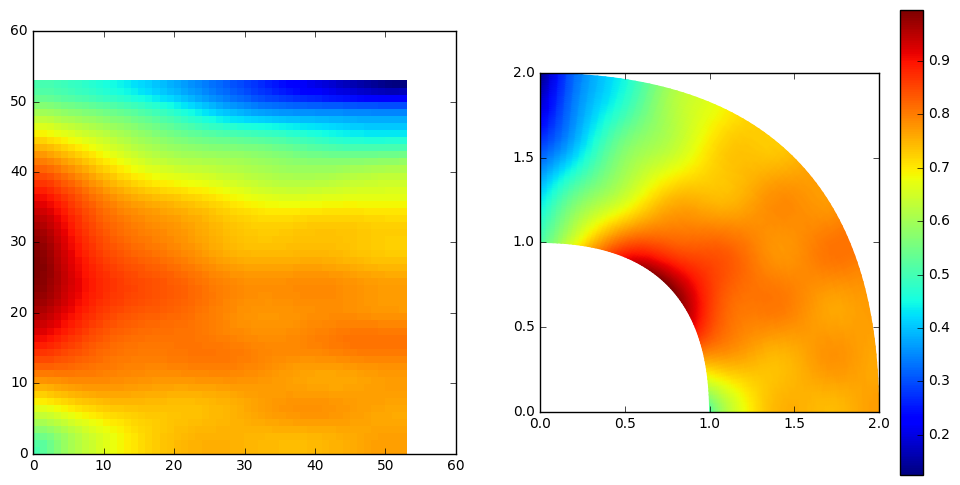

In [7]:
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs);
gca().set_aspect('equal')

subplot(1,2,2)
plot_field(u_func, geo, res=80);
gca().set_aspect('equal')
colorbar();